<a href="https://colab.research.google.com/github/FranceCawich/Assiran_to_English_CNN/blob/main/Assirian_to_english_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

deep_past_initiative_machine_translation_path = kagglehub.competition_download('deep-past-initiative-machine-translation')

print('Data source import complete.')


## Import libaries to be uses tensorflow, keras, numpy and polars

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision, Model
import numpy as np
import polars as pl


In [ ]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

## fix any encoding issue

In [ ]:

def fix_encoding(text):
    if text is None: return ""
    try:
        return text.encode('latin-1').decode('utf-8')
    except:
        return text

## Load trainig Data set

In [ ]:

''' df = pl.read_csv('./sample_data/train.csv') '''

df = pl.read_csv('/kaggle/input/deep-past-initiative-machine-translation/train.csv')

## apply the fix_error encoding function to the data Training data set

In [ ]:
df_clean  = df.with_columns([
    pl.col("transliteration").map_elements(fix_encoding,return_dtype=pl.String),
    pl.col("translation").map_elements(fix_encoding,return_dtype=pl.String)
]).with_columns([(pl.lit("starttoken") + pl.col("translation") + pl.lit("endtoken")).alias("translation_target")])

In [ ]:
source_len = 350
target_len = 450
max_vocab_target = 12000
max_vocab_source = 2000
embed_dim = 256
num_heads = 8
ff_dim = 512

## Create the Tokenization

In [ ]:
source_vec = layers.TextVectorization(
    max_tokens = max_vocab_source,
    output_mode = "int",
    output_sequence_length = source_len
)

target_vec = layers.TextVectorization(
    max_tokens = max_vocab_target,
    output_mode = "int",
    output_sequence_length= target_len + 1

)

source_vec.adapt(df_clean["transliteration"].to_list())
target_vec.adapt(df_clean["translation_target"].to_list())

## Print(view the tokenization list

In [ ]:
vocab = source_vec.get_vocabulary()

for i, word in enumerate(vocab[:5]):
        print(f"ID {i}:{word}")

ID 0:
ID 1:[UNK]
ID 2:ana
ID 3:ša
ID 4:kÙbabbar


## building the Transformer Architexture

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_embeddings = layers.Embedding(vocab_size, embed_dim)
        self.position_embeddings = layers.Embedding(sequence_length, embed_dim)

    def build(self, input_shape):
        """Build the layer - ensures all sublayers are built"""
        self.token_embeddings.build(input_shape)
        self.position_embeddings.build((input_shape[0], self.sequence_length))
        super().build(input_shape)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def get_config(self):
        config = super().get_config()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config

In [ ]:
# transformer encoder

def transformer_encoder(inputs, embed_dim , num_heads , ff_dim):
    x = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)(inputs,inputs,use_causal_mask = True)
    x = layers.LayerNormalization()(inputs + layers.Dropout(0.1)(x))
    f = layers.Dense(ff_dim, activation = "relu")(x)
    f = layers.Dense(embed_dim)(f)
    return layers.LayerNormalization()(x + f)


In [ ]:
#transformer decoder

def transformer_decoder (inputs, enc_out, embed_dim, num_heads, ff_dim):
    x = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)(inputs,inputs, use_causal_mask = True)
    x = layers.LayerNormalization()(inputs + x )
    x2 = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)(x,enc_out)
    x = layers.LayerNormalization()( x + x2)
    f = layers.Dense(ff_dim, activation = "relu")(x)
    f = layers.Dense(embed_dim)(f)
    return layers.LayerNormalization()(x + f)


In [ ]:
## Asembling the model

enc_inputs = layers.Input(shape = (None,), dtype = "int64", name = "assyrian")
dec_inputs = layers.Input(shape = (None,), dtype = "int64", name = "english")

In [ ]:
x = PositionalEmbedding(source_len + 1, max_vocab_source,embed_dim)(enc_inputs)
enc_out = transformer_encoder(x, embed_dim, num_heads, ff_dim)

In [ ]:
x = PositionalEmbedding (target_len + 1, max_vocab_target, embed_dim)(dec_inputs)
dec_out = transformer_decoder(x, enc_out,embed_dim, num_heads, ff_dim)

In [ ]:
outputs = layers.Dense(max_vocab_target, activation = "softmax", dtype='float32')(dec_out)
model = tf.keras.Model([enc_inputs,dec_inputs],outputs)

In [ ]:
model.compile(optimizer = "adam" , loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
source_data = source_vec(df_clean["transliteration"].to_list())
target_data = target_vec(df_clean["translation_target"].to_list())

In [ ]:
dec_in = target_data[:,:-1]
dec_out_labels= target_data[:,1:]

In [ ]:
print( "training model ")

history = model.fit(
    [source_data, dec_in ],
    dec_out_labels,
    batch_size = 8,
    epochs = 30,
    shuffle = True,
    validation_split = 0.2

)

training model 
Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9891 - loss: 0.0418 - val_accuracy: 0.9860 - val_loss: 0.0509
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9881 - loss: 0.0448 - val_accuracy: 0.9808 - val_loss: 0.0669
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9871 - loss: 0.0474 - val_accuracy: 0.9743 - val_loss: 0.0876
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9872 - loss: 0.0472 - val_accuracy: 0.9724 - val_loss: 0.0934
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9898 - loss: 0.0383 - val_accuracy: 0.9700 - val_loss: 0.1014
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9927 - loss: 0.0286 - val_accuracy: 0.9686 - val_loss: 0.1065
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9951 - loss: 0.0214 - val_accuracy: 0.9707 - val_loss: 0.0977
Epoch 8/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9964 - loss: 

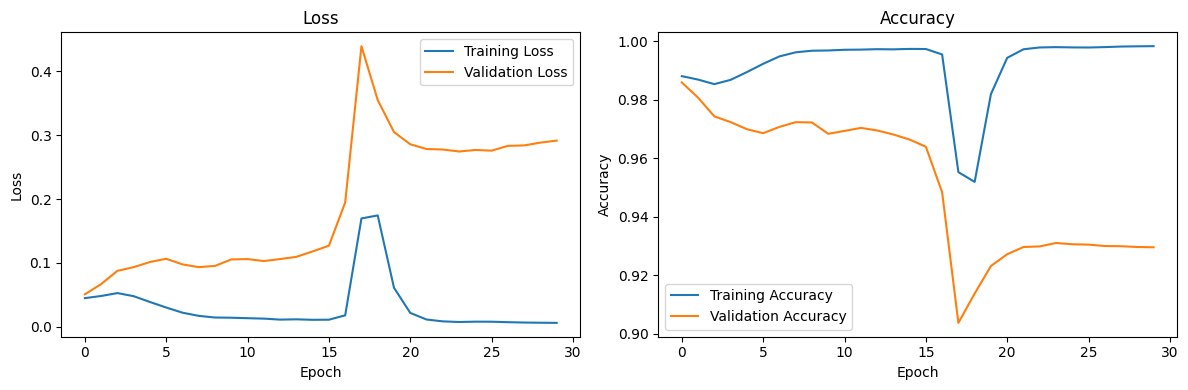

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ assyrian            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │    601,856 │ assyrian[0][0]    │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  2,103,552 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 256) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 256) │          0 │ positional_embed… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 256) │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,187,456 │ english[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 512) │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  2,103,552 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 256) │    131,328 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 256) │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_3[0][0]     

 Total params: 41,137,062 (156.93 MB)

 Trainable params: 13,712,352 (52.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,424,710 (104.62 MB)

In [ ]:
model.save("assyrian_to_english_v1.keras")

## kaggle Submition v1

In [ ]:
## load the test dataset

df_test = pl.read_csv('./sample_data/test.csv')

In [ ]:
#load the train model created preiously
model = tf.keras.models.load_model("./sample_data/assyrian_to_english_v1.keras", custom_objects={'PositionalEmbedding': PositionalEmbedding})

In [ ]:
## REBUILD THE DICTIONARY
df_train = pl.read_csv('./sample_data/train.csv')

In [ ]:
#clean text list

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.replace("-"," ").replace(".", " ").lower()
    return text

In [ ]:
source_vec = tf.keras.layers.TextVectorization(
    max_tokens = 4000,
    output_mode = "int",
    output_sequence_length = 350)

target_vec = tf.keras.layers.TextVectorization(
    max_tokens = 12000,
    output_mode = "int",
    output_sequence_length = 451)

In [ ]:
source_texts = df_train["transliteration"].map_elements(clean_text, return_dtype=str).to_list()
target_texts = (
    ("starttoken" + df_train["translation"] + "endtoken")
    .map_elements(clean_text, return_dtype=str)
    .to_list()
)

In [ ]:
source_vec.adapt(source_texts)
target_vec.adapt(target_texts)

# Get vocabulary
vocab = target_vec.get_vocabulary()
print(f"Source vocabulary size: {len(source_vec.get_vocabulary())}")
print(f"Target vocabulary size: {len(vocab)}")

Source vocabulary size: 533
Target vocabulary size: 4852


In [ ]:
# inference function
def translation_predict(assyrian_text):
    assyrian_text = clean_text(assyrian_text)
    source = source_vec([assyrian_text])

    decode_words = "starttoken"

    for i in range(450):
        tokenized_target = target_vec([decode_words])[:,:-1]
        prediction = model.predict([source,tokenized_target],verbose = 0 )

        sample_token_index = np.argmax(prediction[0, i, :])
        sample_word = vocab[sample_token_index]

        if sample_word == "endtoken":
            break
        decode_words += " " + sample_word

    final_translation = decode_words.replace("starttoken", "").strip()
    return final_translation


In [ ]:
predictions = []
for index, row in enumerate(df_test.iter_rows(named=True)):
    result =  translation_predict(row['transliteration'])
    predictions.append(result)
    if index % 10 == 0:
        print(f"Processed {index} rows.....")

Processed 0 rows.....


In [ ]:
## submition files

submission = pl.DataFrame({ "id": df_test["id"],
                          "translation": predictions})


In [ ]:
submission.write_csv("submission.csv")

In [ ]:
import pickle
import tensorflow as tf # You'll likely need this

# 1. Load the object properly
with open('source_vec.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# Now 'vectorizer' is your Keras layer.
# You can see its vocabulary like this:
vocab = vectorizer.get_vocabulary()
print(vocab[:20]) # Prints the first 20 words it knows

['', '[UNK]', np.str_('a'), np.str_('ma'), np.str_('na'), np.str_('ša'), np.str_('i'), np.str_('ni'), np.str_('šu'), np.str_('lá'), np.str_('ú'), np.str_('kù'), np.str_('um'), np.str_('babbar'), np.str_('ku'), np.str_('tí'), np.str_('x'), np.str_('ta'), np.str_('nu'), np.str_('im')]
